# Task A - Gender Classification Model

 Step 1: Import Libraries

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


 Step 2: Set Dataset Paths

In [2]:

base_dir = 'Comys_Hackathon5/Task_A'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32, class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(128, 128), batch_size=32, class_mode='binary', shuffle=False)


Found 1926 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


 Step 3: Compute Class Weights

In [3]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_generator.classes
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)


Class Weights: {0: np.float64(2.4441624365482233), 1: np.float64(0.6285900783289817)}


 Step 4: Define and Compile Model

In [4]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 64, 64, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 64, 64, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 64, 64, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 64, 64, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 64, 64, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 64, 64, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 64, 64, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 64, 64, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 64, 64, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 64, 64, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 64, 64, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 65, 65, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 32, 32, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Step 5: Training

In [5]:

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

C:\Users\USER\Desktop\hackathon\hackenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6699 - loss: 0.6548 - val_accuracy: 0.8507 - val_loss: 0.3376
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 602ms/step - accuracy: 0.8584 - loss: 0.3670 - val_accuracy: 0.8720 - val_loss: 0.2742
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 43s 707ms/step - accuracy: 0.8655 - loss: 0.3283 - val_accuracy: 0.8602 - val_loss: 0.3126
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 35s 580ms/step - accuracy: 0.8868 - loss: 0.2526 - val_accuracy: 0.8673 - val_loss: 0.2696
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - accuracy: 0.8955 - loss: 0.2681 - val_accuracy: 0.8744 - val_loss: 0.2617
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - accuracy: 0.9067 - loss: 0.2179 - val_accuracy: 0.8839 - val_loss: 0.2486
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.9281 - loss: 0.2100 - val_accuracy: 0.8886 - val_loss: 0.2393
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9189 - loss: 0.2159 - val_accurac

 Step 6: Plot Training History

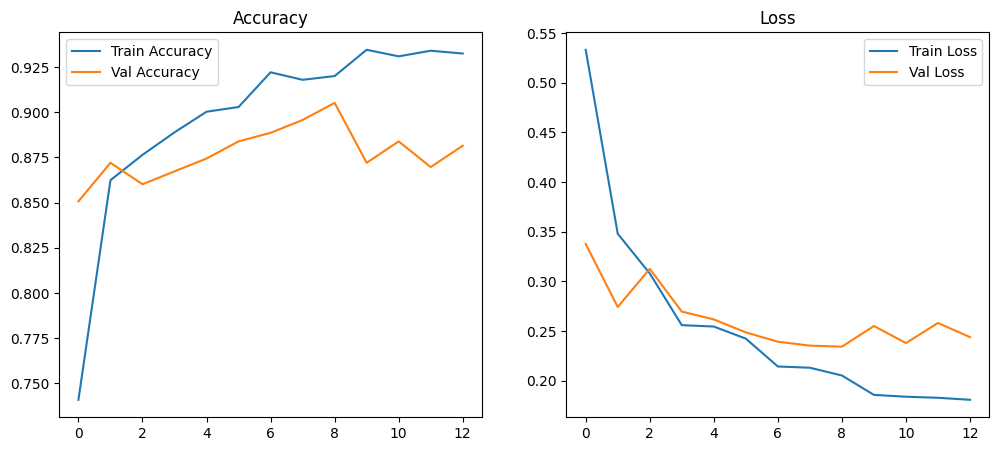

In [6]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


 Step 7: Evaluate Model

In [7]:

val_generator.reset()
preds = model.predict(val_generator)
pred_labels = (preds > 0.5).astype(int).reshape(-1)
true_labels = val_generator.classes

print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=list(val_generator.class_indices.keys())))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step
Classification Report:
              precision    recall  f1-score   support

      female       0.80      0.82      0.81       105
        male       0.94      0.93      0.94       317

    accuracy                           0.91       422
   macro avg       0.87      0.88      0.87       422
weighted avg       0.91      0.91      0.91       422

Confusion Matrix:
[[ 86  19]
 [ 21 296]]


 Step 8: Save Model

In [8]:

model.save('gender_classifier_model.h5')


 Step 9: Save Evaluation Plot

In [9]:
plt.savefig('accuracy_loss_plot.png')


<Figure size 640x480 with 0 Axes>

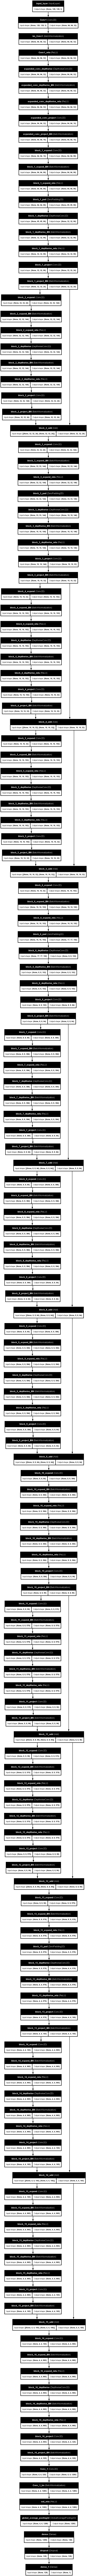

In [4]:
import os
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from IPython.display import Image, display

# ✅ Manually add Graphviz to PATH (adjust if needed)
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"

# ✅ Load model
model = load_model("gender_classifier_model.h5")

# ✅ Plot and display the model diagram
plot_model(model, to_file="taskA_model.png", show_shapes=True, show_layer_names=True)
display(Image(filename="taskA_model.png", width=800)) 

✅ Evaluation Script

A separate Python script test_script.py has been provided to evaluate the trained model on the validation set.

📄 Script Path: test_script.py  
🏷️ Usage:
```bash
python test_script.py gender_classifier_model.h5 Comys_Hackathon5/Task_A/val
